In [3]:
import warnings
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from dataclasses import dataclass
from datasets.dataset import Observable
from typing import Optional
# custom
import torch
import os
import glob
from collections import defaultdict
import sys
sys.path.append(os.path.abspath("../../"))  # Adjust if needed to make `src` importable
from src.utils.plots_utils import hist_weights_plot, hist_line, compute_hist_data, Line


TRUTH_COLOR = "#07078A"
NEUTRAL_COLOR = "black"
NN_COLOR_red = "#8A0707"
NN_COLOR_green = "#06793F"
NN_COLOR_purple = "#790679"
NN_COLORS = {
    "MLP": NN_COLOR_red,
    "Transformer": NN_COLOR_green,
    "LGATr": NN_COLOR_purple,
    "LGATr-3M": "#4C044C",
}
rect = (0.13,0.18,0.95,0.96)
figsize = (6, 4.5)

plt.rc("font", family="serif", size=16)
plt.rc("font", serif="Charter")
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("text", usetex=True)

@dataclass
class Line:
    y: np.ndarray
    y_err: Optional[np.ndarray] = None
    y_ref: Optional[np.ndarray] = None
    label: Optional[str] = None
    color: Optional[str] = None
    linestyle: Optional[str] = "solid"
    fill: bool = False
    vline: bool = False
    alpha: float = 1.0

# Physics utils

In [2]:
minkowski = torch.diag(torch.tensor([1., -1., -1., -1.], dtype=torch.float16))
def covariant2(p1: torch.Tensor, p2: torch.Tensor) -> torch.Tensor:
    """
    Returns the covariant product of two 4-vectors
    """
    # make sure ps and minkowski are the same dtype
    m = minkowski.to(p1.dtype)
    assert p1.dtype == p2.dtype, f"p1 and p2 have different dtypes {p1.dtype} {p2.dtype}"
    return torch.einsum("...i,ij,...j->...", p1, m, p2)

def delta_r(
    p: torch.Tensor, eta1: torch.Tensor, eta2: torch.Tensor, phi1: torch.Tensor, phi2: torch.Tensor
) -> torch.Tensor:
    deta = delta_eta(p, eta1, eta2)
    dphi = delta_phi(p, phi1, phi2)
    return torch.sqrt(deta**2 + dphi**2)


def delta_eta(
    p: torch.Tensor, eta1: torch.Tensor, eta2: torch.Tensor, abs: bool = True
) -> torch.Tensor:
    deta = eta1 - eta2
    return torch.abs(deta) if abs else deta


def delta_phi(
    p: torch.Tensor, phi1: torch.Tensor, phi2: torch.Tensor, abs: bool = True
) -> torch.Tensor:
    dphi = phi1 - phi2
    dphi = (dphi + torch.pi) % (2 * torch.pi) - torch.pi
    return torch.abs(dphi) if abs else dphi

def LorentzProduct(p1, p2, base="EPxPyPz"):
    if base == "PtPhiEtaM":
        p1 = PtPhiEtaM_to_EPxPyPz(p1)
        p2 = PtPhiEtaM_to_EPxPyPz(p2)
    elif base == "EPxPyPz":
        pass
    else:
        raise ValueError(f"Base {base} not recognised")
    return p1[..., 0] * p2[..., 0] - torch.sum(p1[..., 1:] * p2[..., 1:], axis=-1)

def invariant_mass(list_of_p, base="EPxPyPz"):
    """
    list of p is a list of tensors of shape (N, 4) or (N, 3)
    """
    if base == "PtPhiEtaM":
        raise NotImplementedError("PtPhiEtaM not implemented")
    elif base == "EPxPyPz":
        # sum all particles
        stacked = torch.stack(list_of_p, axis=1)   # shape (batch, n_particles, 4)
        summed = stacked.sum(axis=1)          # shape (batch, 4)
        return torch.sqrt(
            summed[..., 0] ** 2 - torch.sum(summed[..., 1:] ** 2, axis=-1)
        )
    
    else:
        raise ValueError(f"Base {base} not recognised")

def mandelstam(p1, p2, p3=None, p4=None, p5=None, p6=None, p7=None, base="EPxPyPz"):
    """
    Mandelstam variable s = (p1 + p2)^2
    """
    if base == "PtPhiEtaM":
        raise NotImplementedError("PtPhiEtaM not implemented")
    elif base == "EPxPyPz":
        # sum all particles
        sqrts = p1+p2
        if p3 is not None:
            sqrts += p3
        if p4 is not None:
            sqrts += p4
        if p5 is not None:
            sqrts += p5
        if p6 is not None:
            sqrts += p6
        if p7 is not None:
            sqrts += p7
        sqrtt = p1-p2
        s = covariant2(sqrts, sqrts)
        t = covariant2(sqrtt, sqrtt)
        return s, t
    
    else:
        raise ValueError(f"Base {base} not recognised")

def PtPhiEtaM_to_EPxPyPz(PtPhiEtaM, cutoff=10):
    if PtPhiEtaM.shape[-1] == 4:
        pt, phi, eta, mass = PtPhiEtaM[:, torch.arange(4)].T
    elif PtPhiEtaM.shape[-1] == 3:
        pt, phi, eta = PtPhiEtaM[:, torch.arange(3)].T
        mass = torch.zeros_like(pt)  # mass is neglected
    else:
        raise ValueError(f"PtPhiEtaM has wrong shape {PtPhiEtaM.shape}")

    px = pt * torch.cos(phi)
    py = pt * torch.sin(phi)
    pz = pt * torch.sinh(torch.clip(eta, -cutoff, cutoff))
    E = torch.sqrt(mass**2 + px**2 + py**2 + pz**2)

    EPxPyPz = torch.stack((E, px, py, pz), axis=-1)
    assert torch.isfinite(
        EPxPyPz
    ).all(), f"{torch.isnan(EPxPyPz).sum(axis=0)} {torch.isinf(EPxPyPz).sum(axis=0)}"
    return EPxPyPz


def EPxPyPz_to_PtPhiEtaM(EPxPyPz):
    pt = get_pt(EPxPyPz)
    phi = get_phi(EPxPyPz)
    eta = get_eta(EPxPyPz)
    mass = get_mass(EPxPyPz)

    PtPhiEtaM = torch.stack((pt, phi, eta, mass), axis=-1)
    assert torch.isfinite(
        PtPhiEtaM
    ).all(), (
        f"{torch.isnan(PtPhiEtaM).sum(axis=0)} {torch.isinf(PtPhiEtaM).sum(axis=0)}"
    )
    return PtPhiEtaM

def get_pt(particle):
    return torch.sqrt(particle[..., 1] ** 2 + particle[..., 2] ** 2)


def get_phi(particle):
    return torch.arctan2(particle[..., 2], particle[..., 1])


def get_eta(particle, eps=1e-10):
    # eta = torch.arctanh(particle[...,3] / p_abs) # numerically unstable
    p_abs = torch.sqrt(torch.sum(particle[..., 1:] ** 2, axis=-1))
    eta = 0.5 * (
        torch.log(torch.clip(torch.abs(p_abs + particle[..., 3]), eps, None))
        - torch.log(torch.clip(torch.abs(p_abs - particle[..., 3]), eps, None))
    )
    return eta


def get_mass(particle, eps=1e-6):
    return torch.sqrt(
        torch.clip(
            particle[..., 0] ** 2 - torch.sum(particle[..., 1:] ** 2, axis=-1),
            eps,
            None,
        )
    )

# Observables utils

In [3]:
def get_hardcoded_bins(n_bins, lower, upper):
    return torch.linspace(lower, upper, n_bins + 1)

def return_obs(p: torch.Tensor, obs: torch.Tensor) -> torch.Tensor:
    return obs

def init_observables(events: torch.Tensor, add_lorentz_products: Optional[bool] = False, add_mandelstam: Optional[bool] = False, add_deltas: Optional[bool] = False) -> list:
    n_particles = (events.shape[-1] - 3) // 4
    observables = []
    n_bins = 50
    for i in range(n_particles):
        observables.append(
            Observable(
                compute=lambda i=i: return_obs(events[..., :], events[..., 4 * i]),
                tex_label=f"E_{{g_{i+1}}}",
                unit="GeV",
                bins=lambda obs: get_hardcoded_bins(
                    n_bins=n_bins + 1, lower=0, upper=1000
                ),
                yscale="linear",
            )
        )
        observables.append(
            Observable(
                compute=lambda i=i: return_obs(events[..., :], events[..., 4 * i + 1]),
                tex_label=f"p_{{x, g_{i+1}}}",
                unit="GeV",
                bins=lambda obs: get_hardcoded_bins(
                    n_bins=n_bins + 1, lower=-500, upper=500
                ),
                yscale="linear",
            )
        )
        observables.append(
            Observable(
                compute=lambda i=i: return_obs(events[..., :], events[..., 4 * i + 2]),
                tex_label=f"p_{{y, g_{i+1}}}",
                unit="GeV",
                bins=lambda obs: get_hardcoded_bins(
                    n_bins=n_bins + 1, lower=-500, upper=500
                ),
                yscale="linear",
            )
        )
        observables.append(
            Observable(
                compute=lambda i=i: return_obs(events[..., :], events[..., 4 * i + 3]),
                tex_label=f"p_{{z, g_{i+1}}}",
                unit="GeV",
                bins=lambda obs: get_hardcoded_bins(
                    n_bins=n_bins + 1, lower=-500, upper=500
                ),
                yscale="linear",
            )
        )
    if add_lorentz_products:
        products = []
        for i in range(n_particles):
            for j in range(i + 1, n_particles):
                products.append(
                    LorentzProduct(
                        events[:, i * 4 : i * 4 + 4], events[:, j * 4 : j * 4 + 4]
                    )
                )
        products = torch.stack(products, axis=-1)
        lorentz_products_events = torch.cat(
            [
                products,
                events[:, -1].unsqueeze(-1),
            ],
            axis=1,
        )
        for i in range(n_particles):
            for j in range(i + 1, n_particles):
                idx = i * n_particles - (i * (i + 1)) // 2 + (j - i - 1)
                observables.append(
                    Observable(
                        compute=lambda idx=idx: return_obs(
                            lorentz_products_events[..., :], lorentz_products_events[..., idx]
                        ),
                        tex_label=f"p_{{g_{i+1}}}\\cdot p_{{g_{j+1}}}",
                        unit=r"\text{GeV}^{2}",
                        bins=(lambda obs: get_hardcoded_bins(
                            n_bins=n_bins + 1, lower=1e4, upper=1e5
                        )) if i == 0 and j == 1 or j == 0 and i == 1 else (lambda obs: get_hardcoded_bins(
                            n_bins=n_bins + 1, lower=0, upper=2e4
                        )),
                        yscale="linear",
                    )
                )
        observables.append(
            Observable(
                compute=lambda: return_obs(
                    lorentz_products_events[..., :], invariant_mass([events[..., 4 * i : 4 * i + 4] for i in range(2, n_particles)])
                ),
                tex_label="m_{\sum_{i=3}^{n}}",
                unit=r"\text{GeV}",
                bins=lambda obs: get_hardcoded_bins(
                    n_bins=n_bins + 1, lower=0, upper=2e3
                ),
                yscale="linear",
            )
        )
        if add_mandelstam:
            observables.append(
                Observable(
                    compute=lambda : return_obs(
                        events[...,:], mandelstam(events[..., 0:4], events[..., 4:8]))[0],
                    tex_label="s_{g_1, g_2}",
                    unit=r"\text{GeV}^{2}",
                    bins=lambda obs: get_hardcoded_bins(
                        n_bins=n_bins + 1, lower=0, upper=5e5
                    ),
                    yscale="linear",
                )
            )
            if n_particles == 6:
                observables.append(
                    Observable(
                        compute=lambda : return_obs(
                            events[...,:], mandelstam(events[..., 8:12], events[..., 12:16], events[..., 16:20], events[..., 20:24]))[0],
                        tex_label="s_{g_3, g_4, g_5, g_6}",
                        unit=r"\text{GeV}^{2}",
                        bins=lambda obs: get_hardcoded_bins(
                            n_bins=n_bins + 1, lower=0, upper=5e5
                        ),
                        yscale="linear",
                    )
                )
            elif n_particles == 7:
                observables.append(
                    Observable(
                        compute=lambda : return_obs(
                            events[...,:], mandelstam(events[..., 8:12], events[..., 12:16], events[..., 16:20], events[..., 20:24]))[0],
                        tex_label="s_{g_3, g_4, g_5, g_6, g_7}",
                        unit=r"\text{GeV}^{2}",
                        bins=lambda obs: get_hardcoded_bins(
                            n_bins=n_bins + 1, lower=0, upper=5e5
                        ),
                        yscale="linear",
                    )
                )
            elif n_particles == 8:
                observables.append(
                    Observable(
                        compute=lambda : return_obs(
                            events[...,:], mandelstam(events[..., 8:12], events[..., 12:16], events[..., 16:20], events[..., 20:24], events[..., 24:28]))[0],
                        tex_label="s_{g_3, g_4, g_5, g_6, g_7, g_8}",
                        unit=r"\text{GeV}^{2}",
                        bins=lambda obs: get_hardcoded_bins(
                            n_bins=n_bins + 1, lower=0, upper=5e5
                        ),
                        yscale="linear",
                    )
                )
            elif n_particles == 9:
                observables.append(
                    Observable(
                        compute=lambda : return_obs(
                            events[...,:], mandelstam(events[..., 8:12], events[..., 12:16], events[..., 16:20], events[..., 20:24], events[..., 24:28], events[..., 28:32]))[0],
                        tex_label="s_{g_3, g_4, g_5, g_6, g_7, g_8, g_9}",
                        unit=r"\text{GeV}^{2}",
                        bins=lambda obs: get_hardcoded_bins(
                            n_bins=n_bins + 1, lower=0, upper=5e5
                        ),
                        yscale="linear",
                    )
                )
            else:
                warnings.warn(
                    f"Cannot compute Mandelstam variables for {n_particles} particles"
                )
        if add_deltas:
            for i in range(n_particles):
                for j in range(i + 1, n_particles):
                    observables.append(
                        Observable(
                            compute=lambda i=i, j=j: return_obs(
                                events[..., :], delta_phi(events[...,:], EPxPyPz_to_PtPhiEtaM(events[..., 4 * i : 4 * i + 4])[..., 1], EPxPyPz_to_PtPhiEtaM(events[..., 4 * j : 4 * j + 4])[..., 1])
                            ),
                            tex_label=f"\Delta \phi (g_{i+1}, g_{j+1})",
                            unit=r"\text{rad}",
                            bins=lambda obs: get_hardcoded_bins(
                                n_bins=n_bins + 1, lower=-0.5, upper=3.5
                            ),
                            yscale="linear",
                        )
                    )
                    observables.append(
                        Observable(
                            compute=lambda i=i, j=j: return_obs(
                                events[..., :], delta_eta(events[...,:], EPxPyPz_to_PtPhiEtaM(events[..., 4 * i : 4 * i + 4])[..., 2], EPxPyPz_to_PtPhiEtaM(events[..., 4 * j : 4 * j + 4])[..., 2])
                            ),
                            tex_label=f"\Delta \eta(g_{i+1}, g_{j+1})",
                            bins=(lambda obs: get_hardcoded_bins(
                                n_bins=n_bins + 1, lower=25, upper=35
                            )) if i == 0 and j == 1 or j == 0 and i == 1 else (lambda obs: get_hardcoded_bins(
                                n_bins=n_bins + 1, lower=10, upper=20
                            )) if i == 0 and j != 1 or j == 0 and i !=1 or i == 1 and j != 0 or j == 1 and i != 0 else (lambda obs: get_hardcoded_bins(
                                n_bins=n_bins + 1, lower=0, upper=8
                            )),
                            yscale="linear",
                        )
                    )
                    observables.append(
                        Observable(
                            compute=lambda i=i, j=j: return_obs(
                                events[..., :], delta_r(events[...,:], EPxPyPz_to_PtPhiEtaM(events[..., 4 * i : 4 * i + 4])[..., 2], EPxPyPz_to_PtPhiEtaM(events[..., 4 * j : 4 * j + 4])[..., 2], EPxPyPz_to_PtPhiEtaM(events[..., 4 * i : 4 * i + 4])[..., 1], EPxPyPz_to_PtPhiEtaM(events[..., 4 * j : 4 * j + 4])[..., 1])
                            ),
                            tex_label=f"\Delta R(g_{i+1}, g_{j+1})",
                            bins=(lambda obs: get_hardcoded_bins(
                                n_bins=n_bins + 1, lower=25, upper=35
                            )) if i == 0 and j == 1 or j == 0 and i == 1 else (lambda obs: get_hardcoded_bins(
                                n_bins=n_bins + 1, lower=10, upper=20
                            )) if i == 0 and j != 1 or j == 0 and i !=1 or i == 1 and j != 0 or j == 1 and i != 0 else (lambda obs: get_hardcoded_bins(
                                n_bins=n_bins + 1, lower=0, upper=8
                            )),
                            yscale="linear",
                        )
                    )

            
    return observables

# Plots

## HET vs MSE

In [8]:
gg_4g_files = [
    "results/MLP/0708_153349-HET-FC-long",
    "results/MLP/0708_153354-HET-r-long",
    "results/MLP/0708_153411-MSE-FC-long",
    "results/MLP/0708_153411-MSE-r-long",
]
gg_5g_files = [
    "results/MLP/0708_175954-5g-HET-FC-long",
    "results/MLP/0708_180012-5g-HET-r-long",
    "results/MLP/0708_182106-5g-MSE-r-long",
    "results/MLP/0708_182601-5g-MSE-FC-long",
]

In [9]:
# I want to now recursively without the use of any function load the files in each directory of gg_4g_files and save results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl

# Load pickle files from each directory and extract specific keys
results = {}
for file_path in gg_4g_files:
    pickle_path = os.path.join("../../", file_path, "pkl", "factors_tst.pkl")
    try:
        with open(pickle_path, "rb") as f:
            data = pickle.load(f)
            # the keys inside results should be either "AFC- or "r- (depending on if FC or r is found on the namefile) and then -MSE" or -HET" depending what is found on the namefile
            if "FC" in file_path:
                key = "AFC"
            elif "r" in file_path:
                key = "r"
            if "MSE" in file_path:
                key += "-MSE"
            elif "HET" in file_path:
                key += "-HET"
            results[key] = {
                "targets-bins" : data[0]["targets-bins"],
                "targets-truth_line": data[0]["targets-lines"][0],
                "targets-NN_line": data[0]["targets-lines"][1],
                'ratios-bins': data[1]["ratios-bins"],
                "ratios-lines": data[1]["ratios-lines"][0],
                "deltas-bins": data[2]["deltas-bins"],
                "deltas-lines": data[2]["deltas-lines"][0],
                "deltas_abs-bins": data[3]["deltas_abs-bins"],
                "deltas_abs-lines": data[3]["deltas_abs-lines"][0],
            }
            print(f"Successfully loaded data from {pickle_path}")
    except Exception as e:
        print(f"Error loading {pickle_path}: {e}")

print(f"Loaded data from {len(results)} files")



Successfully loaded data from ../../results/MLP/0708_153349-HET-FC-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_153411-MSE-FC-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_153411-MSE-r-long/pkl/factors_tst.pkl
Loaded data from 4 files


In [10]:
with PdfPages(f"figs/new_dataset/gg_4g-FC.pdf") as pp:
    results["AFC-MSE"]["targets-truth_line"].label = "Truth"
    results["AFC-MSE"]["targets-NN_line"].label = "MSE"
    results["AFC-MSE"]["targets-NN_line"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["targets-NN_line"].color = NN_COLORS["Transformer"]
    results["AFC-HET"]["targets-NN_line"].label = "HET"
    hist_weights_plot(
        pp,
        lines = [results["AFC-MSE"]["targets-truth_line"], results["AFC-MSE"]["targets-NN_line"], results["AFC-HET"]["targets-NN_line"]],
        bins = results["AFC-MSE"]["targets-bins"],
        show_ratios=True,
        title=r"$gg \to 4g$",
        xlabel=r"$A_{\text{FC}}(x)$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name="MLP",
    )

    results["AFC-MSE"]["ratios-lines"].label = "MSE"
    results["AFC-HET"]["ratios-lines"].label = "HET"
    results["AFC-MSE"]["ratios-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["ratios-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines = [results["AFC-MSE"]["ratios-lines"], results["AFC-HET"]["ratios-lines"]],
        bins = results["AFC-MSE"]["ratios-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$A^{\text{truth}}_{\text{FC}}/A^{\text{pred}}_{\text{FC}}$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["AFC-MSE"]["deltas-lines"].label = "MSE"
    results["AFC-HET"]["deltas-lines"].label = "HET"
    results["AFC-MSE"]["deltas-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["deltas-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines = [results["AFC-MSE"]["deltas-lines"], results["AFC-HET"]["deltas-lines"]],
        bins = results["AFC-MSE"]["deltas-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"${\Delta}_{A_{\text{FC}}} = \frac{A_{\text{FC}}^{\text{pred}} - A_{\text{FC}}^{\text{true}}}{A_{\text{FC}}^{\text{true}}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["AFC-MSE"]["deltas_abs-lines"].label = "MSE"
    results["AFC-HET"]["deltas_abs-lines"].label = "HET"
    results["AFC-MSE"]["deltas_abs-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["deltas_abs-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines = [results["AFC-MSE"]["deltas_abs-lines"], results["AFC-HET"]["deltas_abs-lines"]],
        bins = results["AFC-MSE"]["deltas_abs-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$|{\Delta}_{A_{\text{FC}}}|$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

In [11]:
with PdfPages(f"figs/new_dataset/gg_4g-r.pdf") as pp:
    results["r-MSE"]["targets-truth_line"].label = "Truth"
    results["r-MSE"]["targets-NN_line"].label = "MSE"
    results["r-MSE"]["targets-NN_line"].color = NN_COLORS["MLP"]
    results["r-HET"]["targets-NN_line"].color = NN_COLORS["Transformer"]
    results["r-HET"]["targets-NN_line"].label = "HET"
    hist_weights_plot(
        pp,
        lines = [results["r-MSE"]["targets-truth_line"], results["r-MSE"]["targets-NN_line"], results["r-HET"]["targets-NN_line"]],
        bins = results["r-MSE"]["targets-bins"],
        show_ratios=True,
        title=r"$gg \to 4g$",
        xlabel=r"$r(x)$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name="MLP",
    )

    results["r-MSE"]["ratios-lines"].label = "MSE"
    results["r-HET"]["ratios-lines"].label = "HET"
    results["r-MSE"]["ratios-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["ratios-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines = [results["r-MSE"]["ratios-lines"], results["r-HET"]["ratios-lines"]],
        bins = results["r-MSE"]["ratios-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$r^{\text{truth}}/r^{\text{pred}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["r-MSE"]["deltas-lines"].label = "MSE"
    results["r-HET"]["deltas-lines"].label = "HET"
    results["r-MSE"]["deltas-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["deltas-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines = [results["r-MSE"]["deltas-lines"], results["r-HET"]["deltas-lines"]],
        bins = results["r-MSE"]["deltas-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"${\Delta}_{r} = \frac{r^{\text{pred}} - r^{\text{true}}}{r^{\text{true}}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["r-MSE"]["deltas_abs-lines"].label = "MSE"
    results["r-HET"]["deltas_abs-lines"].label = "HET"
    results["r-MSE"]["deltas_abs-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["deltas_abs-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines = [results["r-MSE"]["deltas_abs-lines"], results["r-HET"]["deltas_abs-lines"]],
        bins = results["r-MSE"]["deltas_abs-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$|{\Delta}_{r}|$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

In [12]:
# I want to now recursively without the use of any function load the files in each directory of gg_4g_files and save results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl

# Load pickle files from each directory and extract specific keys
results = {}
for file_path in gg_5g_files:
    pickle_path = os.path.join("../../", file_path, "pkl", "factors_tst.pkl")
    try:
        with open(pickle_path, "rb") as f:
            data = pickle.load(f)
            # the keys inside results should be either "AFC- or "r- (depending on if FC or r is found on the namefile) and then -MSE" or -HET" depending what is found on the namefile
            if "FC" in file_path:
                key = "AFC"
            elif "r" in file_path:
                key = "r"
            if "MSE" in file_path:
                key += "-MSE"
            elif "HET" in file_path:
                key += "-HET"
            results[key] = {
                "targets-bins" : data[0]["targets-bins"],
                "targets-truth_line": data[0]["targets-lines"][0],
                "targets-NN_line": data[0]["targets-lines"][1],
                'ratios-bins': data[1]["ratios-bins"],
                "ratios-lines": data[1]["ratios-lines"][0],
                "deltas-bins": data[2]["deltas-bins"],
                "deltas-lines": data[2]["deltas-lines"][0],
                "deltas_abs-bins": data[3]["deltas_abs-bins"],
                "deltas_abs-lines": data[3]["deltas_abs-lines"][0],
            }
            print(f"Successfully loaded data from {pickle_path}")
    except Exception as e:
        print(f"Error loading {pickle_path}: {e}")

print(f"Loaded data from {len(results)} files")



Successfully loaded data from ../../results/MLP/0708_175954-5g-HET-FC-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_180012-5g-HET-r-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_182106-5g-MSE-r-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_182601-5g-MSE-FC-long/pkl/factors_tst.pkl
Loaded data from 4 files


In [13]:
with PdfPages(f"figs/new_dataset/gg_5g-FC.pdf") as pp:
    results["AFC-MSE"]["targets-truth_line"].label = "Truth"
    results["AFC-MSE"]["targets-NN_line"].label = "MSE"
    results["AFC-MSE"]["targets-NN_line"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["targets-NN_line"].color = NN_COLORS["Transformer"]
    results["AFC-HET"]["targets-NN_line"].label = "HET"
    hist_weights_plot(
        pp,
        lines = [results["AFC-MSE"]["targets-truth_line"], results["AFC-MSE"]["targets-NN_line"], results["AFC-HET"]["targets-NN_line"]],
        bins = results["AFC-MSE"]["targets-bins"],
        show_ratios=True,
        title=r"$gg \to 5g$",
        xlabel=r"$A_{\text{FC}}(x)$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name="MLP",
    )

    results["AFC-MSE"]["ratios-lines"].label = "MSE"
    results["AFC-HET"]["ratios-lines"].label = "HET"
    results["AFC-MSE"]["ratios-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["ratios-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines = [results["AFC-MSE"]["ratios-lines"], results["AFC-HET"]["ratios-lines"]],
        bins = results["AFC-MSE"]["ratios-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"$A^{\text{truth}}_{\text{FC}}/A^{\text{pred}}_{\text{FC}}$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["AFC-MSE"]["deltas-lines"].label = "MSE"
    results["AFC-HET"]["deltas-lines"].label = "HET"
    results["AFC-MSE"]["deltas-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["deltas-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines = [results["AFC-MSE"]["deltas-lines"], results["AFC-HET"]["deltas-lines"]],
        bins = results["AFC-MSE"]["deltas-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"${\Delta}_{A_{\text{FC}}} = \frac{A_{\text{FC}}^{\text{pred}} - A_{\text{FC}}^{\text{true}}}{A_{\text{FC}}^{\text{true}}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["AFC-MSE"]["deltas_abs-lines"].label = "MSE"
    results["AFC-HET"]["deltas_abs-lines"].label = "HET"
    results["AFC-MSE"]["deltas_abs-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["deltas_abs-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines = [results["AFC-MSE"]["deltas_abs-lines"], results["AFC-HET"]["deltas_abs-lines"]],
        bins = results["AFC-MSE"]["deltas_abs-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"$|{\Delta}_{A_{\text{FC}}}|$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

In [14]:
with PdfPages(f"figs/new_dataset/gg_5g-r.pdf") as pp:
    results["r-MSE"]["targets-truth_line"].label = "Truth"
    results["r-MSE"]["targets-NN_line"].label = "MSE"
    results["r-MSE"]["targets-NN_line"].color = NN_COLORS["MLP"]
    results["r-HET"]["targets-NN_line"].color = NN_COLORS["Transformer"]
    results["r-HET"]["targets-NN_line"].label = "HET"
    hist_weights_plot(
        pp,
        lines = [results["r-MSE"]["targets-truth_line"], results["r-MSE"]["targets-NN_line"], results["r-HET"]["targets-NN_line"]],
        bins = results["r-MSE"]["targets-bins"],
        show_ratios=True,
        title=r"$gg \to 5g$",
        xlabel=r"$r(x)$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name="MLP",
    )

    results["r-MSE"]["ratios-lines"].label = "MSE"
    results["r-HET"]["ratios-lines"].label = "HET"
    results["r-MSE"]["ratios-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["ratios-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines = [results["r-MSE"]["ratios-lines"], results["r-HET"]["ratios-lines"]],
        bins = results["r-MSE"]["ratios-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"$r^{\text{truth}}/r^{\text{pred}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["r-MSE"]["deltas-lines"].label = "MSE"
    results["r-HET"]["deltas-lines"].label = "HET"
    results["r-MSE"]["deltas-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["deltas-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines = [results["r-MSE"]["deltas-lines"], results["r-HET"]["deltas-lines"]],
        bins = results["r-MSE"]["deltas-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"${\Delta}_{r} = \frac{r^{\text{pred}} - r^{\text{true}}}{r^{\text{true}}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["r-MSE"]["deltas_abs-lines"].label = "MSE"
    results["r-HET"]["deltas_abs-lines"].label = "HET"
    results["r-MSE"]["deltas_abs-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["deltas_abs-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines = [results["r-MSE"]["deltas_abs-lines"], results["r-HET"]["deltas_abs-lines"]],
        bins = results["r-MSE"]["deltas_abs-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"$|{\Delta}_{r}|$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

## Regression plots

### Histograms

In [8]:
gg_4g_files = [
    "results/MLP/0722_230341-r-gg_4g-mse-lr_1e-3",
    "results/Transformer/0722_230433-r-gg_4g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0722_231238-r-gg_4g-mse-pdrop_0-lr_1e-3",
]
gg_5g_files = [
    "results/MLP/0722_230341-r-gg_5g-mse-lr_1e-3",
    "results/Transformer/0722_230445-r-gg_5g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0722_231241-r-gg_5g-mse-pdrop_0-lr_1e-3",
]
gg_g_files = [    
    "results/MLP/0722_230341-r-gg_6g-mse-lr_1e-3",
    "results/Transformer/0722_230445-r-gg_6g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0722_231249-r-gg_6g-mse-pdrop_0-lr_1e-3",
]
gg_7g_files = [
    "results/MLP/0722_230341-r-gg_7g-mse-lr_1e-3",
    "results/Transformer/0722_230438-r-gg_7g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0722_231249-r-gg_7g-mse-pdrop_0-lr_1e-3",
]

gg_ddbar2g_files = [
    "results/MLP/0728_000117-r-gg_ddbar2g-mse-pdrop_0p1-lr_1e-3",
    "results/Transformer/0727_235728-r-gg_ddbar2g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0728_001832-r-gg_ddbar2g-mse-pdrop_0-lr_1e-3",
]
gg_ddbar3g_files = [
    "results/MLP/0728_000129-r-gg_ddbar3g-mse-pdrop_0p1-lr_1e-3",
    "results/Transformer/0727_235729-r-gg_ddbar3g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0728_001839-r-gg_ddbar3g-mse-pdrop_0-lr_1e-3",
]
gg_ddbar4g_files = [
    "results/MLP/0728_000129-r-gg_ddbar4g-mse-pdrop_0p1-lr_1e-3",
    "results/Transformer/0727_235732-r-gg_ddbar4g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0728_001839-r-gg_ddbar4g-mse-pdrop_0-lr_1e-3",
]
gg_ddbar5g_files = [   
    "results/MLP/0728_000129-r-gg_ddbar5g-mse-pdrop_0p1-lr_1e-3",
    "results/Transformer/0727_235735-r-gg_ddbar5g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0728_001839-r-gg_ddbar5g-mse-pdrop_0-lr_1e-3",
]

In [10]:
# I want to now recursively without the use of any function load the files in each directory of gg_4g_files and save results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl

# Load pickle files from each directory and extract specific keys
results = {}
for files in [gg_4g_files, gg_5g_files, gg_g_files, gg_7g_files, gg_ddbar2g_files, gg_ddbar3g_files, gg_ddbar4g_files, gg_ddbar5g_files]:
    for file_path in files:
        pickle_path = os.path.join("../../", file_path, "pkl", "factors_tst.pkl")
        try:
            with open(pickle_path, "rb") as f:
                data = pickle.load(f)
                # the keys inside results should be either "AFC- or "r- (depending on if FC or r is found on the namefile) and then -MSE" or -HET" depending what is found on the namefile
                if "MLP" in file_path:
                    key = "MLP"
                elif "Transformer" in file_path:
                    key = "Transformer"
                elif "LGATr" in file_path:
                    key = "LGATr"
                else:
                    print(f"Unknown model in file path: {file_path}")
                #
                # to be modified
                #
                if "gg_4g" in file_path:
                    key += "-gg_4g"
                elif "gg_5g" in file_path:
                    key += "-gg_5g"
                elif "gg_6g" in file_path:
                    key += "-gg_6g"
                elif "gg_7g" in file_path:
                    key += "-gg_7g"
                elif "gg_ddbar2g" in file_path:
                    key += "-gg_ddbar2g"
                elif "gg_ddbar3g" in file_path:
                    key += "-gg_ddbar3g"
                elif "gg_ddbar4g" in file_path:
                    key += "-gg_ddbar4g"
                elif "gg_ddbar5g" in file_path:
                    key += "-gg_ddbar5g"
                else:
                    print(f"Unknown process in file path: {file_path}")
                results[key] = {
                    "targets-bins" : data[0]["targets-bins"],
                    "targets-truth_line": data[0]["targets-lines"][0],
                    "targets-NN_line": data[0]["targets-lines"][1],
                    'ratios-bins': data[1]["ratios-bins"],
                    "ratios-lines": data[1]["ratios-lines"][0],
                    "deltas-bins": data[2]["deltas-bins"],
                    "deltas-lines": data[2]["deltas-lines"][0],
                    "deltas_abs-bins": data[3]["deltas_abs-bins"],
                    "deltas_abs-lines": data[3]["deltas_abs-lines"][0],
                }
                print(f"Successfully loaded data from {pickle_path}")
        except Exception as e:
            print(f"Error loading {pickle_path}: {e}")

    print(f"Loaded data from {len(results)} files")
print(results.keys())


Successfully loaded data from ../../results/MLP/0722_230341-r-gg_4g-mse-lr_1e-3/pkl/factors_tst.pkl
Successfully loaded data from ../../results/Transformer/0722_230433-r-gg_4g-mse-pdrop_0p1-lr_1e-3/pkl/factors_tst.pkl
Successfully loaded data from ../../results/LGATr/0722_231238-r-gg_4g-mse-pdrop_0-lr_1e-3/pkl/factors_tst.pkl
Loaded data from 3 files
Successfully loaded data from ../../results/MLP/0722_230341-r-gg_5g-mse-lr_1e-3/pkl/factors_tst.pkl
Successfully loaded data from ../../results/Transformer/0722_230445-r-gg_5g-mse-pdrop_0p1-lr_1e-3/pkl/factors_tst.pkl
Successfully loaded data from ../../results/LGATr/0722_231241-r-gg_5g-mse-pdrop_0-lr_1e-3/pkl/factors_tst.pkl
Loaded data from 6 files
Successfully loaded data from ../../results/MLP/0722_230341-r-gg_6g-mse-lr_1e-3/pkl/factors_tst.pkl
Successfully loaded data from ../../results/Transformer/0722_230445-r-gg_6g-mse-pdrop_0p1-lr_1e-3/pkl/factors_tst.pkl
Successfully loaded data from ../../results/LGATr/0722_231249-r-gg_6g-mse-pd

In [11]:
processes = [
    "gg_4g", "gg_5g", "gg_6g", "gg_7g",
    "gg_ddbar2g", "gg_ddbar3g", "gg_ddbar4g", "gg_ddbar5g",
]
process_names = {
    "gg_4g": r"$gg \to 4g$",
    "gg_5g": r"$gg \to 5g$",
    "gg_6g": r"$gg \to 6g$",
    "gg_7g": r"$gg \to 7g$",
    "gg_ddbar2g": r"$gg \to d\bar{d} + 2g$",
    "gg_ddbar3g": r"$gg \to d\bar{d} + 3g$",
    "gg_ddbar4g": r"$gg \to d\bar{d} + 4g$",
    "gg_ddbar5g": r"$gg \to d\bar{d} + 5g$",
}
for process in ["gg_ddbar2g", "gg_ddbar3g", "gg_ddbar4g", "gg_ddbar5g"]:
    with PdfPages(f"figs/new_dataset/regression/{process}.pdf") as pp:
        hist_weights_plot(
            pp,
            lines = [results[f"MLP-{process}"]["targets-truth_line"], results[f"MLP-{process}"]["targets-NN_line"], results[f"Transformer-{process}"]["targets-NN_line"], results[f"LGATr-{process}"]["targets-NN_line"]],
            bins = results[f"MLP-{process}"]["targets-bins"],
            show_ratios=True,
            title=process_names[process],
            xlabel=r"$r(x)$",
            xscale="linear",
            no_scale=True,
            metrics=None,
            model_name=None,
        )

        hist_weights_plot(
        pp,
        lines = [results[f"MLP-{process}"]["ratios-lines"], results[f"Transformer-{process}"]["ratios-lines"], results[f"LGATr-{process}"]["ratios-lines"]],
        bins = results[f"MLP-{process}"]["ratios-bins"],
        show_ratios=False,
        title=process_names[process],
        xlabel=r"$r^{\text{truth}}/r^{\text{pred}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
        )

        hist_weights_plot(
            pp,
            lines = [results[f"MLP-{process}"]["deltas-lines"], results[f"Transformer-{process}"]["deltas-lines"], results[f"LGATr-{process}"]["deltas-lines"]],
            bins = results[f"MLP-{process}"]["deltas-bins"],
            show_ratios=False,
            title=process_names[process],
            xlabel=r"${\Delta}_{r} = \frac{r^{\text{pred}} - r^{\text{true}}}{r^{\text{true}}}$",
            xscale="linear",
            no_scale=True,
            metrics=None,
            model_name=None,
        )

        hist_weights_plot(
            pp,
            lines = [results[f"MLP-{process}"]["deltas_abs-lines"], results[f"Transformer-{process}"]["deltas_abs-lines"], results[f"LGATr-{process}"]["deltas_abs-lines"]],
            bins = results[f"MLP-{process}"]["deltas_abs-bins"],
            show_ratios=False,
            title=process_names[process],
            xlabel=r"$|{\Delta}_{r}|$",
            xscale="log",
            no_scale=True,
            metrics=None,
            model_name=None,
        )

### Unweighting efficiency and evaluation time

In [49]:
eval_time = {
    "gg_4g": { "MLP": 3.410, "Transformer": 4.463, "LGATr": 13.961 },
    "gg_5g": { "MLP": 3.411, "Transformer": 4.364, "LGATr": 15.454 },
    "gg_6g": { "MLP": 3.425, "Transformer": 4.554, "LGATr": 17.074 },
    "gg_7g": { "MLP": 3.405, "Transformer": 4.968, "LGATr": 18.399 },

    "gg_ddbar2g": { "MLP": 3.383, "Transformer": 4.518, "LGATr": 14.432 },
    "gg_ddbar3g": { "MLP": 3.368, "Transformer": 4.727, "LGATr": 15.628 },
    "gg_ddbar4g": { "MLP": 3.236, "Transformer": 4.784, "LGATr": 17.289 },
    "gg_ddbar5g": { "MLP": 3.527, "Transformer": 5.027, "LGATr": 18.615 },
} 

unw_efficiency1 = {
    "gg_4g": { "MLP": 0.885, "Transformer": 0.874, "LGATr": 0.875,  },
    "gg_5g": { "MLP": 0.801, "Transformer": 0.786, "LGATr": 0.789,  },
    "gg_6g": { "MLP": 0.660, "Transformer": 0.680, "LGATr": 0.674,  },
    "gg_7g": { "MLP": 0.585, "Transformer": 0.558, "LGATr": 0.567,  },

    "gg_ddbar2g": { "MLP": 0.903, "Transformer": 0.902, "LGATr": 0.901,  },
    "gg_ddbar3g": { "MLP": 0.808, "Transformer": 0.807, "LGATr": 0.814,  },
    "gg_ddbar4g": { "MLP": 0.748, "Transformer": 0.739, "LGATr": 0.735,  },
    "gg_ddbar5g": { "MLP": 0.686, "Transformer": 0.626, "LGATr": 0.654,  },
}
unw_efficiency2 = {
    "gg_4g": { "MLP": 0.951, "Transformer": 0.977, "LGATr": 0.956, "standard" : 0.863},
    "gg_5g": { "MLP": 0.864, "Transformer": 0.897, "LGATr": 0.904, "standard" : 0.779},
    "gg_6g": { "MLP": 0.790, "Transformer": 0.875, "LGATr": 0.797, "standard" : 0.634},
    "gg_7g": { "MLP": 0.637, "Transformer": 0.824, "LGATr": 0.797, "standard" : 0.491},

    "gg_ddbar2g": { "MLP": 0.825, "Transformer": 0.893, "LGATr": 0.864, "standard" : 0.901},
    "gg_ddbar3g": { "MLP": 0.795, "Transformer": 0.858, "LGATr": 0.769, "standard" : 0.803},
    "gg_ddbar4g": { "MLP": 0.711, "Transformer": 0.837, "LGATr": 0.766, "standard" : 0.708},
    "gg_ddbar5g": { "MLP": 0.663, "Transformer": 0.751, "LGATr": 0.779, "standard" : 0.639},
}

ds_names = {
    "gg_4g": r"$gg \to 4g$",
    "gg_5g": r"$gg \to 5g$",
    "gg_6g": r"$gg \to 6g$",
    "gg_7g": r"$gg \to 7g$",
    "gg_ddbar2g": r"$gg \to d\bar{d} + 2g$",
    "gg_ddbar3g": r"$gg \to d\bar{d} + 3g$",
    "gg_ddbar4g": r"$gg \to d\bar{d} + 4g$",
    "gg_ddbar5g": r"$gg \to d\bar{d} + 5g$",
}

/tmp/ipykernel_1469572/3189840414.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  **{ds: cm.get_cmap('tab20', len(gg_ng))(i) for i, ds in enumerate(gg_ng)},
/tmp/ipykernel_1469572/3189840414.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  **{ds: cm.get_cmap('tab20b', len(gg_ddbar))(i) for i, ds in enumerate(gg_ddbar)}


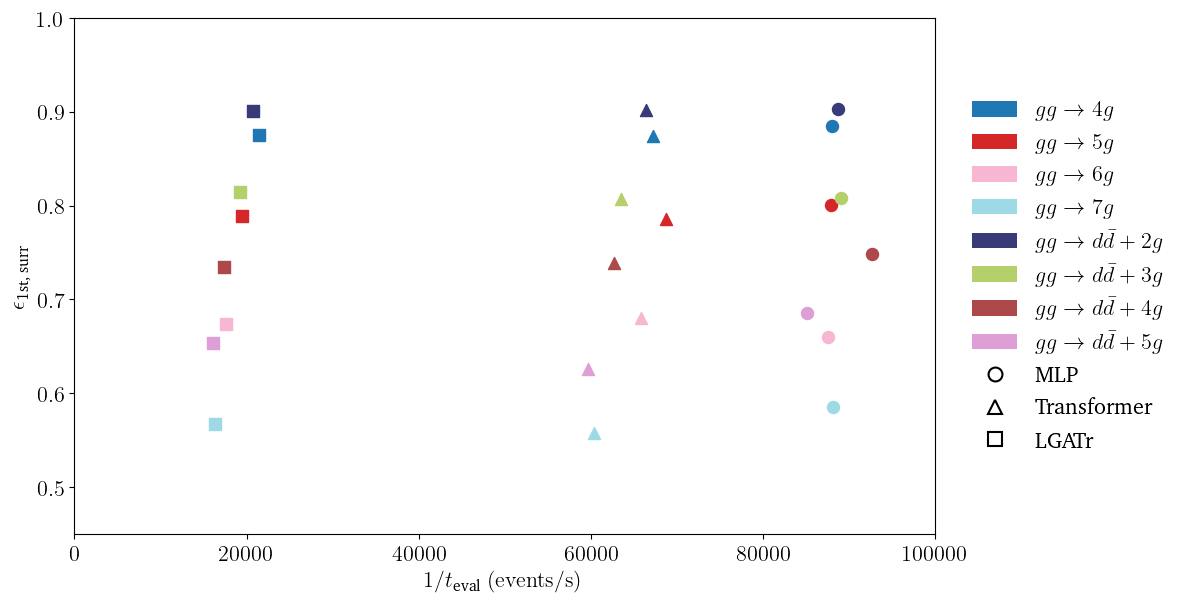

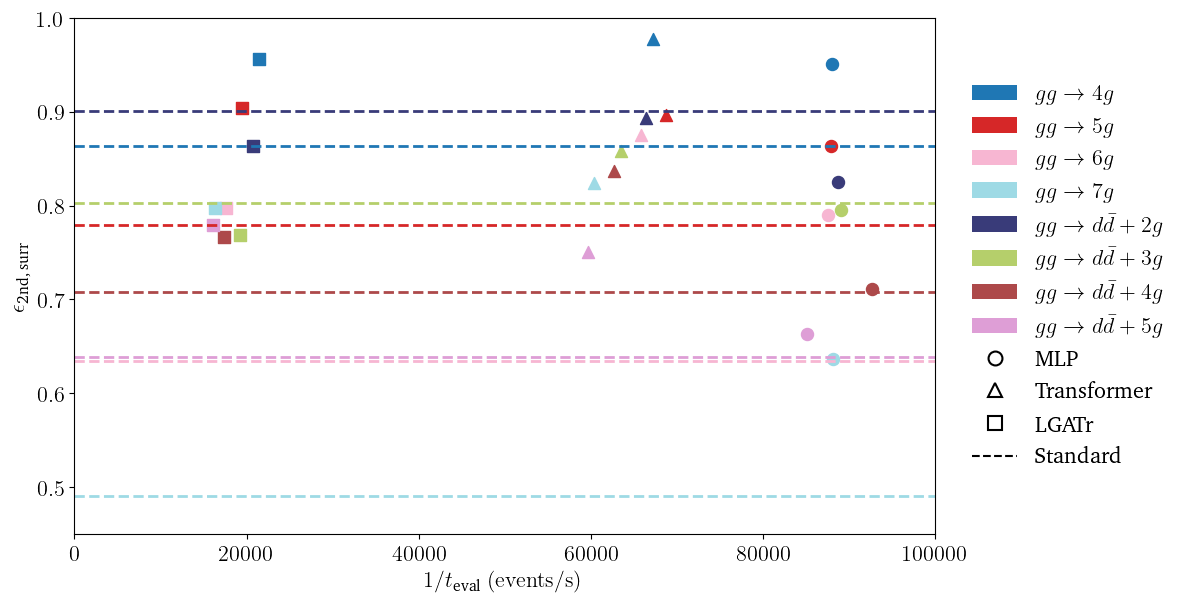

In [50]:
# Prepare colors and markers
datasets = list(eval_time.keys())
networks = list(next(iter(eval_time.values())).keys())

# Split datasets
gg_ng = sorted([ds for ds in datasets if "ddbar" not in ds])
gg_ddbar = sorted([ds for ds in datasets if "ddbar" in ds])

# Assign different colormaps
dataset_colors = {
    **{ds: cm.get_cmap('tab20', len(gg_ng))(i) for i, ds in enumerate(gg_ng)},
    **{ds: cm.get_cmap('tab20b', len(gg_ddbar))(i) for i, ds in enumerate(gg_ddbar)}
}
network_markers = {'MLP': 'o', 'Transformer': '^', 'LGATr': 's'}

with PdfPages("figs/new_dataset/regression/eff_vs_evalt.pdf") as pp:
    for i, eff in enumerate([unw_efficiency1, unw_efficiency2]):
        eff_label = [r"$\epsilon_{\text{1st, surr}}$", r"$\epsilon_{\text{2nd, surr}}$"][i]
        fig, ax = plt.subplots(figsize=(2.*figsize[0], 1.3*figsize[1]))
        fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=(0.05, 0.05, 0.81, 1))  # left, bottom, right, top margins
        # ax.grid()
        if i == 1:
            for ds in datasets:
                ax.axhline(
                    eff[ds]["standard"],
                    color=dataset_colors[ds],
                    linestyle='--',
                    linewidth=2,
                    alpha=1,
                )
        for ds in datasets:
            for net in networks:
                x = 1 / (eval_time[ds][net] / 300_000)
                y = eff[ds][net]
                ax.scatter(
                    x, y,
                    color=dataset_colors[ds],
                    marker=network_markers[net],
                    s=75,
                )
        dataset_handles = [
            Patch(facecolor=dataset_colors[ds], label=ds_names[ds])
            for ds in sorted(datasets)
        ]
        network_handles = [
            plt.Line2D(
                [0], [0],
                marker=network_markers[net],
                color='none',                   # No fill
                markerfacecolor='none',        # Transparent fill
                markeredgecolor='black',       # Black border (or use dataset color if you want)
                linestyle='',
                label=net,
                markersize=10,
                markeredgewidth=1.5
            )
            for net in networks
        ]
        if i == 1:
            standard_handle = plt.Line2D([0], [0], color='black', linestyle='--', label='Standard')

        # Combine both types into a single legend
        combined_handles = dataset_handles + network_handles + int(i==1) * [standard_handle]
        combined_labels = [h.get_label() for h in combined_handles]

        # Add legend outside
        ax.legend(
            handles=combined_handles,
            labels=combined_labels,
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            frameon=False,
            ncol=1,
        )


        ax.set_xlabel(r"$1 / t_{\text{eval}}\ (\mathrm{events / s})$")
        ax.set_ylabel(eff_label)

        handles, labels = ax.get_legend_handles_labels()
        ax.set_ylim(0.45, 1.)
        ax.set_xlim(0, 100_000)
        fig.savefig(pp, format="pdf")

## Grokking studies

In [40]:
files = [
    "results/Transformer/Grokking/0724_095354-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_095354-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_095355-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_100335-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101053-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101227-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101238-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101258-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_110133-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_110817-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_120203-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_120206-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_120340-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_123618-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_124655-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_130211-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_134328-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_152444-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_152505-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_152524-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_161432-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_162201-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_164337-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_164820-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_165334-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_173928-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_174029-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_175321-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_175533-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_175738-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181039-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181206-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181839-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181908-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182145-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182246-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182459-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182502-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182751-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_184727-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_185958-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_191353-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_191936-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_192440-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_192958-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_193238-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_193629-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_193915-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_194000-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_195438-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181250-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181308-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181333-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181358-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181422-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181447-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181512-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181537-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181611-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181629-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3"
]

In [41]:
def load(path: str, name: str):
    """
    Loads the model, preprocessing, optimizer and losses.

    Args:
        name: File name for the model (without path and extension)
    """
    state_dict_attrs = [
        "net", "optimizer", "scheduler"
    ]
    file = os.path.join(path, f"{name}.pth")
    state_dicts = torch.load(file)
    losses = state_dicts["losses"]
    return losses
    # for attr in state_dict_attrs:
    #     try:
    #         getattr(self, attr).load_state_dict(state_dicts[attr])
    #     except AttributeError:
    #         pass

In [42]:
# I want to now recursively without the use of any function load the files in each directory of gg_4g_files and save results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl

# Load pickle files from each directory and extract specific keys
results = {}
emb_12 = []
emb_18 = []
emb_24 = []
emb_48 = []
emb_72 = []
emb_96 = []
for file_path in files:
    path = os.path.join("../../", file_path)
    try:
        losses = load(os.path.join(path, "model"), "final")
        # the keys inside results should be either "AFC- or "r- (dependilosses on if FC or r is found on the namefile) and then -MSE" or -HET" dependilosses what is found on the namefile
        if "emb_12" in file_path:
            label = "emb_12"
            emb_12.append(losses)
        elif "emb_18" in file_path:
            label = "emb_18"
            emb_18.append(losses)
        elif "emb_24" in file_path:
            label = "24"
            emb_24.append(losses)
        elif "emb_48" in file_path:
            label = "48"
            emb_48.append(losses)
        elif "emb_72" in file_path:
            label = "72"
            emb_72.append(losses)
        elif "emb_96" in file_path:
            label = "96"
            emb_96.append(losses)
        else:
            raise ValueError(f"Unknown embedding size in file path: {file_path}")
    except Exception as e:
        print(f"Error loading {pickle_path}: {e}")

for key, l in zip(["emb_12", "emb_18", "emb_24", "emb_48", "emb_72", "emb_96"], [emb_12, emb_18, emb_24, emb_48, emb_72, emb_96]):
    results[key] = l
    print(key, len(l), "files loaded")

emb_12 10 files loaded
emb_18 10 files loaded
emb_24 10 files loaded
emb_48 10 files loaded
emb_72 10 files loaded
emb_96 10 files loaded


In [43]:
for k in results:
    for file_losses in results[k]:
        print(len(file_losses['val']))

171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171


In [51]:

plt.rc("font", family="serif", size=16)
plt.rc("font", serif="Charter")
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("text", usetex=True)
dims = [12, 18, 24, 48, 72, 96]
import matplotlib.cm as cm
cmap = cm.get_cmap("viridis")  # continuous

lo, hi = .1, .9  # pick your range
n_models = len(results)
positions = np.linspace(lo, hi, n_models)
train_cols = [cmap(p) for p in reversed(positions)]
# train_cols = [f"C{i}"                     for i in range(n_models)]
# val_cols   = [f"C{i + 2 + 2*n_models}"    for i in range(n_models)]
val_cols = train_cols.copy()
with PdfPages("figs/new_dataset/grok-gg_4g-losses-all.pdf") as pp:
    for dim in dims:
        fig, ax = plt.subplots(figsize=figsize)
        fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=rect)

        for idx, (name, runs) in enumerate(results.items()):
            if name != f"emb_{dim}":
                continue
            train_c, val_c = train_cols[idx], val_cols[idx]
            emb_label       = name.split('_')[1]

            max_len_val  = len(runs[0]["val"])
            val_matrix   = np.zeros((max_len_val, len(runs)))
            trn_matrix   = np.zeros((len(runs[0]["trn"]), len(runs)))


            position_where_val_crosses_0p1 = np.zeros((len(runs)))
            for run_idx, run in enumerate(runs):
                trn = np.array(run["trn"])
                val = np.array(run["val"])


                N = len(trn)
                M = len(val)
                factor = N // M
                avg_trn = np.array([trn[i*factor:(i+1)*factor].mean() for i in range(M)])
                std_trn = np.array([trn[i*factor:(i+1)*factor].std() for i in range(M)])
                x_avg_trn = np.arange(1, M + 1) * factor  # same scale as val

                ax.plot(
                    x_avg_trn, avg_trn,
                    color=train_c, linestyle="dashed", alpha=0.5,
                    label=f"Train ({emb_label})" if run_idx == 0 else ""
                )
                # Plot std fill
                ax.fill_between(
                    x_avg_trn,
                    avg_trn - std_trn,
                    avg_trn + std_trn,
                    color=train_c,
                    alpha=0.1,
                    linewidth=0,
                    rasterized=True  # helps keep PDF small
                )



                # x_trn = np.arange(1, len(trn) + 1)
                # # ax.plot(
                # #     x_trn, trn,
                # #     color=train_c, linestyle="solid", alpha=0.2,
                # #     label=f"Train ({emb_label})" if run_idx == 0 else ""
                # # )

                scale = len(trn) / len(val)           # handles early‑stop curves
                x_val = np.arange(1, len(val) + 1) * scale
                ax.plot(
                    x_val, val,
                    # marker="o", markersize=3, markeredgewidth=0.6,
                    color=val_c, linestyle="solid", alpha=.9,
                    label=f"Val ({emb_label})" if run_idx == 0 else ""
                )

                # store for mean curve
                # val_matrix[:len(val), run_idx] = val
                trn_matrix[:len(trn), run_idx] = trn
                position_where_val_crosses_0p1[run_idx] = x_val[val < 0.1].min() if np.any(val < 0.1) else 50_000
                # break
            # mean_val = np.mean(val_matrix, axis=1)
            # ax.plot(
            #     x_val, mean_val,
            #     color=val_c, linestyle="solid",
            #     label=f"Avg. Val. ({emb_label})"
            # )
            # mean_trn = np.mean(trn_matrix, axis=1)
            # ax.plot(
            #     x_trn, mean_trn,
            #     color=train_c, linestyle="solid",
            #     label=f"Avg. Trn. ({emb_label})",
            #     alpha=0.2,
            # )
            if not np.all(np.isnan(position_where_val_crosses_0p1)):
                # ax.axhline(
                #     0.1, color="black", linestyle="dashed", alpha=0.1, 
                # )
                # for pos in position_where_val_crosses_0p1:
                #     if not np.isnan(pos):
                #         ax.axvline(
                #             pos, color=val_c, linestyle="dotted", alpha=0.5,
                #         )
                ax.axvline(
                    np.nanmean(position_where_val_crosses_0p1),
                    color=val_c, linestyle="dotted", alpha=1., linewidth = 3,
                )

                ax.text(
                    2275,
                    0.0075, 
                    rf"$\text{{Avg. It}}_{{\text{{MSE}}<0.1}} = {np.nanmean(position_where_val_crosses_0p1):.0f}\pm {np.nanstd(position_where_val_crosses_0p1):.0f}$",
                    color="black", fontsize=14, ha="left", va="center", rotation=0,
                    alpha=1.0
                )
                
                # ax.fill_between(
                #     [position_where_val_crosses_0p1.mean() - position_where_val_crosses_0p1.std(),
                #         position_where_val_crosses_0p1.mean() + position_where_val_crosses_0p1.std()],
                #     0, 100,
                #     color=val_c, alpha=0.1,
                # )

        # ------------------------------------------------------------------
        # y‑axis scale: purely log if all training losses > 0, otherwise symlog
        # (same criterion as original—last loop’s 'run' is still in scope)
        # ------------------------------------------------------------------
        ax.set_yscale("log" if np.all(np.array(run["trn"]) > 0) else "symlog")

        # ------------------------------------------------------------------
        ax.set_ylim(0.005, 2)
        ax.set_xlim(0, 50000)
        ax.set_xlabel("Training Iterations")
        ax.set_ylabel("MSE loss")
        ax.xaxis.get_major_formatter().set_useOffset(False)
        ax.xaxis.get_major_formatter().set_scientific(False)

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, frameon=False, loc="upper center", ncol=2, handlelength=1.0)
        fig.savefig(pp, format="pdf")
        plt.close(fig)


/tmp/ipykernel_802240/1674953196.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")  # continuous


### Different iterations

In [9]:
path = "../../results/Transformer/Grokking/0724_120206-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3/model"
it_20217 = np.load(os.path.join(path, "preds_vs_targets_20217.npy"), allow_pickle=True).item()
# it_30179 = np.load(os.path.join(path, "preds_vs_targets_30179.npy"), allow_pickle=True).item()
# it_38383 = np.load(os.path.join(path, "preds_vs_targets_38383.npy"), allow_pickle=True).item()
it_34867 = np.load(os.path.join(path, "preds_vs_targets_34867.npy"), allow_pickle=True).item()
it_40434 = np.load(os.path.join(path, "preds_vs_targets_40434.npy"), allow_pickle=True).item()
it_49810 = np.load(os.path.join(path, "preds_vs_targets_49810.npy"), allow_pickle=True).item()
losses = load(path, "final")

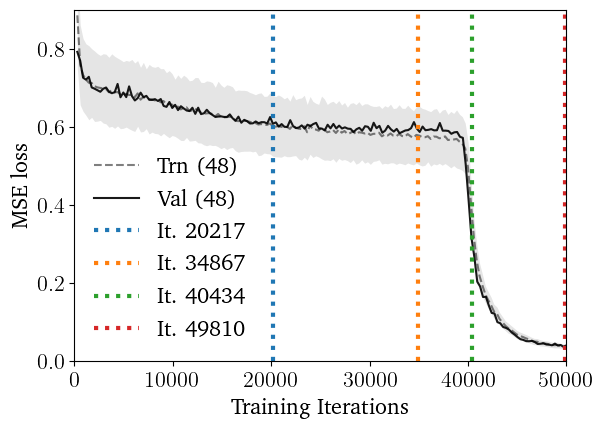

In [ ]:

iterations_checks = [
    20217, 34867, 40434, 49810
]
colors = [f"C{i}" for i in range(len(iterations_checks))]
with PdfPages("figs/new_dataset/its_comparison.pdf") as pp:
    fig, ax = plt.subplots(figsize=figsize)
    fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=rect)
    trn = np.array(losses["trn"])
    val = np.array(losses["val"])

    N = len(trn)
    M = len(val)
    factor = N // M
    avg_trn = np.array([trn[i*factor:(i+1)*factor].mean() for i in range(M)])
    std_trn = np.array([trn[i*factor:(i+1)*factor].std() for i in range(M)])
    x_avg_trn = np.arange(1, M + 1) * factor  # same scale as val

    ax.plot(
        x_avg_trn, avg_trn,
        color="black", linestyle="dashed", alpha=0.5,
        label=f"Trn (48)"
    )
    # Plot std fill
    ax.fill_between(
        x_avg_trn,
        avg_trn - std_trn,
        avg_trn + std_trn,
        color="black",
        alpha=0.1,
        linewidth=0,
        rasterized=True  # helps keep PDF small
    )



    # x_trn = np.arange(1, len(trn) + 1)
    # # ax.plot(
    # #     x_trn, trn,
    # #     color=train_c, linestyle="solid", alpha=0.2,
    # #     label=f"Train ({emb_label})" if run_idx == 0 else ""
    # # )

    scale = len(trn) / len(val)           # handles early‑stop curves
    x_val = np.arange(1, len(val) + 1) * scale
    ax.plot(
        x_val, val,
        # marker="o", markersize=3, markeredgewidth=0.6,
        color="black", linestyle="solid", alpha=.9,
        label=f"Val (48)"
    )
    for i, c in enumerate(colors):
        ax.axvline(
            iterations_checks[i],
            color=c,
            linestyle="dotted", alpha=1., linewidth = 3,
            label=f"It. {iterations_checks[i]}"
        )
    ax.set_yscale("linear")
    ax.set_ylim(0.000, 0.9)
    ax.set_xlim(0, 50000)
    ax.set_xlabel("Training Iterations")
    ax.set_ylabel("MSE loss")
    ax.xaxis.get_major_formatter().set_useOffset(False)
    ax.xaxis.get_major_formatter().set_scientific(False)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, frameon=False, loc="lower left")
    fig.subplots_adjust(left=rect[0], bottom=rect[1], right=rect[2], top=rect[3])
    fig.savefig(pp, format="pdf")

    truth = it_20217["targets"]
    preds_20217 = it_20217["preds"]
    preds_34867 = it_34867["preds"]
    preds_40434 = it_40434["preds"]
    preds_49810 = it_49810["preds"]

    bins = np.linspace(
            *np.percentile(
                np.concatenate([
                    truth,
                    preds_20217,
                    preds_34867,
                    preds_40434,
                    preds_49810,
                ]),
                [0, 100]
            ),
            64,
    )
    y_truth, y_err = compute_hist_data(
        bins, truth, bayesian=False
    )
    y_preds_20217, y_err_20217 = compute_hist_data(
        bins, preds_20217, bayesian=False
    )
    y_preds_34867, y_err_34867 = compute_hist_data(
        bins, preds_34867, bayesian=False
    )
    y_preds_40434, y_err_40434 = compute_hist_data(
        bins, preds_40434, bayesian=False
    )
    y_preds_49810, y_err_49810 = compute_hist_data(
        bins, preds_49810, bayesian=False
    )
    lines = [
        Line(
            y=y_truth,
            y_err=y_err,
            label="Truth",
            color=TRUTH_COLOR,
        )
    ]
    for c, (y_preds, y_err_preds, it) in enumerate(zip(
        [y_preds_20217, y_preds_34867, y_preds_40434, y_preds_49810],
        [y_err_20217, y_err_34867, y_err_40434, y_err_49810],
        iterations_checks
    )):
        lines.append(
            Line(
                y=y_preds,
                y_err=y_err_preds,
                y_ref=y_truth,
                label=f"Preds. It. {it}",
                color=colors[c],
                alpha=0.5
            )
        )

    hist_weights_plot(
        pp,
        lines,
        bins,
        show_ratios=False,
        xlabel= f"$\\tilde{{r}}(x)$",
        xscale="linear",
        title=r"$gg\to 4g$",
        no_scale=True,
        rect=rect,
    )

In [38]:
gg_4g_files = [
    "results/Transformer/0720_200047-r-gg_4g-mse-pdrop_0-arctanh_F-lr_1e-3",
    "results/Transformer/0720_200047-r-gg_4g-mse-pdrop_0-arctanh_F-lr_1e-4",
    "results/Transformer/0720_200047-r-gg_4g-mse-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/0720_200051-r-gg_4g-mse-pdrop_0-arctanh_T-lr_1e-3",
    "results/Transformer/0720_200052-r-gg_4g-het-pdrop_0-arctanh_F-lr_1e-3",
    "results/Transformer/0720_200052-r-gg_4g-het-pdrop_0-arctanh_T-lr_1e-3",
    "results/Transformer/0720_200052-r-gg_4g-mse-pdrop_0-arctanh_T-lr_1e-4",
    "results/Transformer/0720_200106-r-gg_4g-het-pdrop_0-arctanh_T-lr_1e-4",
    "results/Transformer/0720_200107-r-gg_4g-het-pdrop_0p1-arctanh_F-lr_1e-4",
    "results/Transformer/0720_201716-r-gg_4g-het-pdrop_0p1-arctanh_T-lr_1e-3",
    "results/Transformer/0720_201829-r-gg_4g-het-pdrop_0p1-arctanh_T-lr_1e-4",
    "results/Transformer/0720_205830-r-gg_4g-het-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/0721_001321-r-gg_4g-mse-pdrop_0p1-arctanh_T-lr_1e-3",
    "results/Transformer/0721_012140-r-gg_4g-mse-pdrop_0p1-arctanh_T-lr_1e-4",
    "results/Transformer/0721_012944-r-gg_4g-mse-pdrop_0p1-arctanh_F-lr_1e-4",
    "results/Transformer/0721_022744-r-gg_4g-het-pdrop_0-arctanh_F-lr_1e-4"
]

In [39]:
# I want to now recursively without the use of any function load the files in each directory of gg_4g_files and save results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl

# Load pickle files from each directory and extract specific keys
results = {}
for file_path in gg_4g_files:
    pickle_path = os.path.join("../../", file_path, "pkl", "factors_tst.pkl")
    try:
        with open(pickle_path, "rb") as f:
            data = pickle.load(f)
            # the keys inside results should be either "AFC- or "r- (depending on if FC or r is found on the namefile) and then -MSE" or -HET" depending what is found on the namefile
            if "FC" in file_path:
                key = "AFC"
            elif "r" in file_path:
                key = "r"
            if "mse" in file_path:
                key += "-MSE"
            elif "het" in file_path:
                key += "-HET"
            if "pdrop_0-" in file_path:
                key += "-pdrop_0"
            elif "pdrop_0p1" in file_path:
                key += "-pdrop_0p1"
            if "arctanh_F" in file_path:
                pass
            elif "arctanh_T" in file_path:
                key += "-atanh"
            if "lr_1e-3" in file_path:
                key += "-lr_1e-3"
            elif "lr_1e-4" in file_path:
                key += "-lr_1e-4"
            
            results[key] = {
                "targets-bins" : data[0]["targets-bins"],
                "targets-truth_line": data[0]["targets-lines"][0],
                "targets-NN_line": data[0]["targets-lines"][1],
                'ratios-bins': data[1]["ratios-bins"],
                "ratios-lines": data[1]["ratios-lines"][0],
                "deltas-bins": data[2]["deltas-bins"],
                "deltas-lines": data[2]["deltas-lines"][0],
                "deltas_abs-bins": data[3]["deltas_abs-bins"],
                "deltas_abs-lines": data[3]["deltas_abs-lines"][0],
            }
            print(f"Successfully loaded data from {pickle_path} with key {key}")
    except Exception as e:
        print(f"Error loading {pickle_path}: {e}")

print(f"Loaded data from {len(results)} files")

Successfully loaded data from ../../results/Transformer/0720_200047-r-gg_4g-mse-pdrop_0-arctanh_F-lr_1e-3/pkl/factors_tst.pkl with key r-MSE-pdrop_0-lr_1e-3
Successfully loaded data from ../../results/Transformer/0720_200047-r-gg_4g-mse-pdrop_0-arctanh_F-lr_1e-4/pkl/factors_tst.pkl with key r-MSE-pdrop_0-lr_1e-4
Successfully loaded data from ../../results/Transformer/0720_200047-r-gg_4g-mse-pdrop_0p1-arctanh_F-lr_1e-3/pkl/factors_tst.pkl with key r-MSE-pdrop_0p1-lr_1e-3
Successfully loaded data from ../../results/Transformer/0720_200051-r-gg_4g-mse-pdrop_0-arctanh_T-lr_1e-3/pkl/factors_tst.pkl with key r-MSE-pdrop_0-atanh-lr_1e-3
Successfully loaded data from ../../results/Transformer/0720_200052-r-gg_4g-het-pdrop_0-arctanh_F-lr_1e-3/pkl/factors_tst.pkl with key r-HET-pdrop_0-lr_1e-3
Successfully loaded data from ../../results/Transformer/0720_200052-r-gg_4g-het-pdrop_0-arctanh_T-lr_1e-3/pkl/factors_tst.pkl with key r-HET-pdrop_0-atanh-lr_1e-3
Successfully loaded data from ../../result

In [58]:
with PdfPages(f"figs/new_dataset/grok/gg_4g-r-reduced.pdf") as pp:
    results["r-MSE-pdrop_0-lr_1e-3"]["targets-truth_line"].label = "Truth"
    lines = []
    lines.append(results["r-MSE-pdrop_0-lr_1e-3"]["targets-truth_line"])
    bins = results["r-MSE-pdrop_0-lr_1e-3"]["targets-bins"]
    for i, k in enumerate(results.keys()):
        if k == "r-MSE-pdrop_0p1-lr_1e-4" or k == "r-MSE-pdrop_0p1-lr_1e-3" or k == "r-HET-pdrop_0-lr_1e-3" or k == "r-HET-pdrop_0-lr_1e-4" or k == "r-MSE-pdrop_0-lr_1e-3" or k == "r-MSE-pdrop_0-atanh-lr_1e-4" or k == "r-MSE-pdrop_0p1-atanh-lr_1e-4" or k == "r-MSE-pdrop_0-atanh-lr_1e-3" or k == "r-HET-pdrop_0p1-lr_1e-3" or k == "r-HET-pdrop_0p1-atanh-lr_1e-4" or k == "r-MSE-pdrop_0-lr_1e-4":
            print(f"Skipping {k}")
            continue
        assert np.all(bins == results[k]["targets-bins"]), f"Bins mismatch for {k}"
        results[k]["targets-NN_line"].color = f"C{i}"
        results[k]["targets-NN_line"].label = k[2:]
        lines.append(results[k]["targets-NN_line"])
    hist_weights_plot(
        pp,
        lines = lines,
        bins = bins,
        show_ratios=True,
        title=r"$gg \to 4g$",
        xlabel=r"$r(x)$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name="Transformer",
        size_multipler=1.2
    )

    lines = []
    bins = results["r-MSE-pdrop_0-lr_1e-3"]["ratios-bins"]
    for i, k in enumerate(results.keys()):
        if k == "r-MSE-pdrop_0p1-lr_1e-4" or k == "r-MSE-pdrop_0p1-lr_1e-3" or k == "r-HET-pdrop_0-lr_1e-3" or k == "r-HET-pdrop_0-lr_1e-4" or k == "r-MSE-pdrop_0-lr_1e-3" or k == "r-MSE-pdrop_0-atanh-lr_1e-4" or k == "r-MSE-pdrop_0p1-atanh-lr_1e-4" or k == "r-MSE-pdrop_0-atanh-lr_1e-3" or k == "r-HET-pdrop_0p1-lr_1e-3" or k == "r-HET-pdrop_0p1-atanh-lr_1e-4" or k == "r-MSE-pdrop_0-lr_1e-4":
            print(f"Skipping {k}")
            continue
        assert np.all(bins == results[k]["ratios-bins"]), f"Bins mismatch for {k}"
        results[k]["ratios-lines"].color = f"C{i}"
        results[k]["ratios-lines"].label = k[2:]
        lines.append(results[k]["ratios-lines"])
    hist_weights_plot(
        pp,
        lines = lines,
        bins = bins,
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$r^{\text{truth}}/r^{\text{pred}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name="Transformer",
        size_multipler=1.2
    )

    lines = []
    bins = results["r-MSE-pdrop_0-lr_1e-3"]["deltas-bins"]
    for i, k in enumerate(results.keys()):
        if k == "r-MSE-pdrop_0p1-lr_1e-4" or k == "r-MSE-pdrop_0p1-lr_1e-3" or k == "r-HET-pdrop_0-lr_1e-3" or k == "r-HET-pdrop_0-lr_1e-4" or k == "r-MSE-pdrop_0-lr_1e-3" or k == "r-MSE-pdrop_0-atanh-lr_1e-4" or k == "r-MSE-pdrop_0p1-atanh-lr_1e-4" or k == "r-MSE-pdrop_0-atanh-lr_1e-3" or k == "r-HET-pdrop_0p1-lr_1e-3" or k == "r-HET-pdrop_0p1-atanh-lr_1e-4" or k == "r-MSE-pdrop_0-lr_1e-4":
            print(f"Skipping {k}")
            continue
        assert np.all(bins == results[k]["deltas-bins"]), f"Bins mismatch for {k}"
        results[k]["deltas-lines"].color = f"C{i}"
        results[k]["deltas-lines"].label = k[2:]
        lines.append(results[k]["deltas-lines"])
    hist_weights_plot(
        pp,
        lines = lines,
        bins = bins,
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"${\Delta}_{r} = \frac{r^{\text{pred}} - r^{\text{true}}}{r^{\text{true}}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name="Transformer",
        size_multipler=1.2
    )

   
    lines = []
    bins = results["r-MSE-pdrop_0-lr_1e-3"]["deltas_abs-bins"]
    for i, k in enumerate(results.keys()):
        if k == "r-MSE-pdrop_0p1-lr_1e-4" or k == "r-MSE-pdrop_0p1-lr_1e-3" or k == "r-HET-pdrop_0-lr_1e-3" or k == "r-HET-pdrop_0-lr_1e-4" or k == "r-MSE-pdrop_0-lr_1e-3" or k == "r-MSE-pdrop_0-atanh-lr_1e-4" or k == "r-MSE-pdrop_0p1-atanh-lr_1e-4" or k == "r-MSE-pdrop_0-atanh-lr_1e-3" or k == "r-HET-pdrop_0p1-lr_1e-3" or k == "r-HET-pdrop_0p1-atanh-lr_1e-4" or k == "r-MSE-pdrop_0-lr_1e-4":
            print(f"Skipping {k}")
            continue
        assert np.all(np.isclose(bins, results[k]["deltas_abs-bins"])), f"Bins mismatch for {k}"
        results[k]["deltas_abs-lines"].color = f"C{i}"
        results[k]["deltas_abs-lines"].label = k[2:]
        lines.append(results[k]["deltas_abs-lines"])

    hist_weights_plot(
        pp,
        lines = lines,
        bins = bins,
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$|{\Delta}_{r}|$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name="Transformer",
        size_multipler=1.2
    )

Skipping r-MSE-pdrop_0-lr_1e-3
Skipping r-MSE-pdrop_0-lr_1e-4
Skipping r-MSE-pdrop_0p1-lr_1e-3
Skipping r-MSE-pdrop_0-atanh-lr_1e-3
Skipping r-HET-pdrop_0-lr_1e-3
Skipping r-MSE-pdrop_0-atanh-lr_1e-4
Skipping r-HET-pdrop_0p1-atanh-lr_1e-4
Skipping r-HET-pdrop_0p1-lr_1e-3
Skipping r-MSE-pdrop_0p1-atanh-lr_1e-4
Skipping r-MSE-pdrop_0p1-lr_1e-4
Skipping r-HET-pdrop_0-lr_1e-4
Skipping r-MSE-pdrop_0-lr_1e-3
Skipping r-MSE-pdrop_0-lr_1e-4
Skipping r-MSE-pdrop_0p1-lr_1e-3
Skipping r-MSE-pdrop_0-atanh-lr_1e-3
Skipping r-HET-pdrop_0-lr_1e-3
Skipping r-MSE-pdrop_0-atanh-lr_1e-4
Skipping r-HET-pdrop_0p1-atanh-lr_1e-4
Skipping r-HET-pdrop_0p1-lr_1e-3
Skipping r-MSE-pdrop_0p1-atanh-lr_1e-4
Skipping r-MSE-pdrop_0p1-lr_1e-4
Skipping r-HET-pdrop_0-lr_1e-4
Skipping r-MSE-pdrop_0-lr_1e-3
Skipping r-MSE-pdrop_0-lr_1e-4
Skipping r-MSE-pdrop_0p1-lr_1e-3
Skipping r-MSE-pdrop_0-atanh-lr_1e-3
Skipping r-HET-pdrop_0-lr_1e-3
Skipping r-MSE-pdrop_0-atanh-lr_1e-4
Skipping r-HET-pdrop_0p1-atanh-lr_1e-4
Skipping r-

In [ ]:
results["r-HET-pdrop_0-atanh-lr_1e-4"]["deltas_abs-bins"]

array([1.00000000e-06, 1.20050806e-06, 1.44121960e-06, 1.73019574e-06,
       2.07711393e-06, 2.49359200e-06, 2.99357729e-06, 3.59381366e-06,
       4.31440226e-06, 5.17947468e-06, 6.21800109e-06, 7.46476041e-06,
       8.96150502e-06, 1.07583590e-05, 1.29154967e-05, 1.55051578e-05,
       1.86140669e-05, 2.23463373e-05, 2.68269580e-05, 3.22059792e-05,
       3.86635375e-05, 4.64158883e-05, 5.57226480e-05, 6.68954879e-05,
       8.03085722e-05, 9.64110880e-05, 1.15742288e-04, 1.38949549e-04,
       1.66810054e-04, 2.00256814e-04, 2.40409918e-04, 2.88614044e-04,
       3.46483486e-04, 4.15956216e-04, 4.99358789e-04, 5.99484250e-04,
       7.19685673e-04, 8.63988449e-04, 1.03722510e-03, 1.24519708e-03,
       1.49486913e-03, 1.79460244e-03, 2.15443469e-03, 2.58641621e-03,
       3.10501350e-03, 3.72759372e-03, 4.47500630e-03, 5.37228112e-03,
       6.44946677e-03, 7.74263683e-03, 9.29509790e-03, 1.11588399e-02,
       1.33962772e-02, 1.60823388e-02, 1.93069773e-02, 2.31781818e-02,
      

# Load data

In [5]:
data_dir = "../../data/gg_ng/large/" if os.path.exists("../../data/gg_ng/large/") else "/remote/gpu02/marino/data/gg_ng/large/"
datasets_names = ["gg_4g", "gg_5g", "gg_6g", "gg_7g"]
# read data and pass to tensors
datasets = {
    datasets_names[0]: np.load(os.path.join(data_dir, "events_6_2_21_21_21_21_21_21_1_2_3_4_5_6.lhe.rwgt.npy")),
    datasets_names[1]: np.load(os.path.join(data_dir, "events_7_2_21_21_21_21_21_21_21_1_2_3_4_5_6_7.lhe.rwgt.npy")),
    datasets_names[2]: np.load(os.path.join(data_dir, "events_8_2_21_21_21_21_21_21_21_21_1_2_3_4_5_6_7_8.lhe.rwgt.npy")),
    datasets_names[3]: np.load(os.path.join(data_dir, "events_9_2_21_21_21_21_21_21_21_21_21_1_2_3_4_5_6_7_8_9.lhe.rwgt.npy")),
}

In [9]:
!pwd

/remote/gpu02/marino/MadRecolor/madrecolor/src/playground


In [ ]:
!ls ../../../../data

autojump  bin  data  GPTs  include  lib  lib64	MadRecolor  Unfolding


# Understanding the dataset

In [ ]:
for (process_name, dataset) in zip(datasets.keys(), datasets.values()):

    observables_initd = init_observables(torch.from_numpy(dataset), add_lorentz_products=True, add_mandelstam=True, add_deltas=True)
    observables = []
    obs_list = []
    bins_list = []
    for obs in observables_initd:
        o = obs.compute()
        bin = obs.bins(o)
        observables.append(obs)
        obs_list.append(o.cpu().numpy())
        bins_list.append(bin.cpu().numpy())
    
    plot_observables(
        observables,
        bins_list,
        obs_list,
        process_name=f"${process_name[:2]}\\to {process_name[-2:]}$",
        file=f"figs/dataset/{process_name}-filtered_secondarypeak.pdf",
        model_name="NN",
        mask=(np.log(dataset[:,-1]) - np.mean(np.log(dataset[:,-1]))) / np.std(np.log(dataset[:,-1])) < -0.9,
        no_scale=True,
    )

In [8]:
dataset = datasets["gg_4g"]
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Assume p is your tensor of shape (N, D)
X = dataset[:, :-3]  # Features
y = dataset[:, -1]   # Target

# Fit a model
model = RandomForestRegressor(n_estimators=2).fit(X, y)

In [9]:
# Create SHAP explainer
explainer = shap.Explainer(model, X)

# Compute SHAP values
shap_values = explainer(X)

# Beeswarm plot
shap.summary_plot(shap_values, X)


: 

In [19]:
np.arange(2, 7 * 4, 4)

array([ 2,  6, 10, 14, 18, 22, 26])

# Benchmarks

## Weights and ratio correlations

In [156]:
# Load samples from 
datasets = ["gg_4g", "gg_5g", "gg_6g", "gg_7g"]
events = defaultdict(lambda: defaultdict(dict))
samples = defaultdict(lambda: defaultdict(dict))
models = ["Transformer", "MLP", "LGATr", "LGATr-3M"]
for model in models:
    for dataset in datasets:
        for split in ["tst"]:
            path = glob.glob(f"files/benchmarks/Transformer/*-benchmark-{dataset}/samples/events_{split}.pt")[0]
            events[dataset][split] = torch.load(path, map_location="cpu").squeeze().numpy()
            if model == "Transformer":
                samples[dataset][model][split] = torch.load(glob.glob(f"files/benchmarks/{model}/*-benchmark-{dataset}*one_hot/samples/predicted_factors_{split}.pt")[0], map_location="cpu").squeeze().numpy()
            else:
                samples[dataset][model][split] = torch.load(glob.glob(f"files/benchmarks/{model}/*-benchmark-{dataset}*/samples/predicted_factors_{split}.pt")[0], map_location="cpu").squeeze().numpy()

In [105]:
for process_name in datasets:
    plot_weights(
        events[process_name],
        samples[process_name],
        process_name=f"${process_name[:2]}\\to {process_name[-2:]}$",
        file=f"figs/benchmarks/{process_name}-weights.pdf",
        split="tst",
    )
    for model in models:
        plot_ratio_correlation(
            events[process_name],
            samples[process_name][model],
            process_name=f"${process_name[:2]}\\to {process_name[-2:]}$",
            file=f"figs/benchmarks/{process_name}-{model}-ratio_corr.pdf",
            model_name=model,
            split="tst",
        )

## Validation losses

In [106]:
def load_model_paths(base_dir, models, datasets):
    model_dict = defaultdict(dict)
    pattern = os.path.join(base_dir, "**", "model", "best.pth")
    model_paths = glob.glob(pattern, recursive=True)
    print(model_paths)

    for path in model_paths:
        # Break path into parts
        parts = path.split(os.sep)

        # Search for the "benchmarks" index to locate model and run folder
        try:
            bench_idx = parts.index("benchmarks")
            model = parts[bench_idx + 1]
            run_folder = parts[bench_idx + 2]
        except (ValueError, IndexError):
            continue

        # Extract dataset from run folder name like "0415_153319-benchmark-gg_4g"
        if "-benchmark-" in run_folder:
            dataset = run_folder.split("-benchmark-")[-1]
        else:
            continue

        if model in models and dataset in datasets:
            model_dict[dataset][model] = path

    return model_dict

# Example usage
base_folder = "/Users/jamarino/Documents/Heidelberg/Work/MadRecolor/madrecolor/src/playground/files/benchmarks"
models = ["Transformer", "MLP", "LGATr", "LGATr-3M"]
datasets = ["gg_4g", "gg_5g", "gg_6g", "gg_7g"]

model_dict = dict(sorted(load_model_paths(base_folder, models, datasets).items()))

best_val_models = defaultdict(dict)
best_val = defaultdict(dict)

for dataset in datasets:
    for model in models:
        path = model_dict.get(dataset, {}).get(model, None)
        if path:
            print(f"{dataset} - {model}")
            best_val_models[dataset][model] = torch.load(path, map_location=torch.device('cpu'))
            loss_vals = best_val_models[dataset][model]["losses"]["val"]
            assert loss_vals[-1] == min(loss_vals)
            assert np.argmin(loss_vals)+1 == len(loss_vals)
            best_val[dataset][model] = np.min(loss_vals)
            print("Best_val_loss:", best_val[dataset][model])


['/Users/jamarino/Documents/Heidelberg/Work/MadRecolor/madrecolor/src/playground/files/benchmarks/Transformer/0416_012532-benchmark-gg_6g-one_hot/model/best.pth', '/Users/jamarino/Documents/Heidelberg/Work/MadRecolor/madrecolor/src/playground/files/benchmarks/Transformer/0415_182151-benchmark-gg_4g-one_hot/model/best.pth', '/Users/jamarino/Documents/Heidelberg/Work/MadRecolor/madrecolor/src/playground/files/benchmarks/Transformer/0415_153238-benchmark-gg_4g/model/best.pth', '/Users/jamarino/Documents/Heidelberg/Work/MadRecolor/madrecolor/src/playground/files/benchmarks/Transformer/0415_153307-benchmark-gg_7g/model/best.pth', '/Users/jamarino/Documents/Heidelberg/Work/MadRecolor/madrecolor/src/playground/files/benchmarks/Transformer/0416_044055-benchmark-gg_7g-one_hot/model/best.pth', '/Users/jamarino/Documents/Heidelberg/Work/MadRecolor/madrecolor/src/playground/files/benchmarks/Transformer/0415_215149-benchmark-gg_5g-one_hot/model/best.pth', '/Users/jamarino/Documents/Heidelberg/Work/

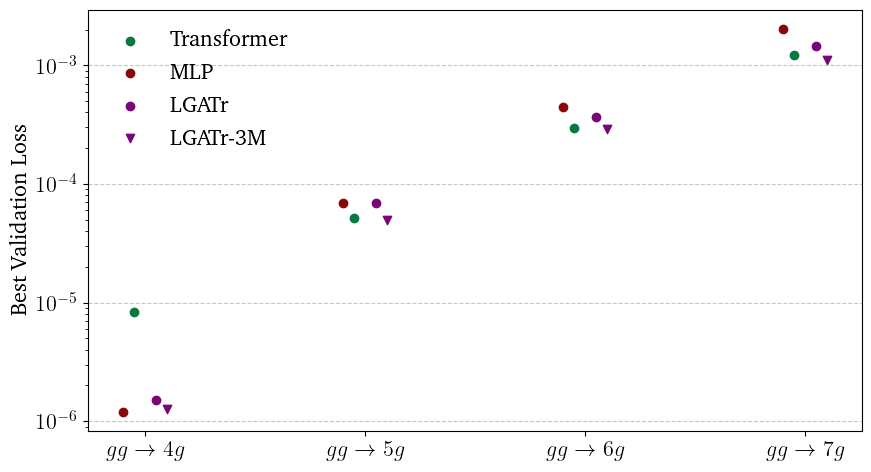

In [107]:
# Create x positions for the datasets
x = np.arange(len(datasets))
fig, ax = plt.subplots(figsize=(9, 5))

offsets = {
    "MLP": -0.1,
    "Transformer": -0.05,
    "LGATr": 0.05,
    "LGATr-3M": 0.1,
}
for model in models:
    # For each dataset, get the best validation loss for the current model.
    # If a model is missing for a dataset, use np.nan.
    y = [best_val[ds].get(model, np.nan) for ds in datasets]
    if model =="LGATr-3M":
        # Plot the data with a different color
        ax.scatter(x + offsets[model], y, marker="v", label=model, color = NN_COLORS["LGATr"])
    else:
        ax.scatter(x + offsets[model], y, marker='o', label=model, color = NN_COLORS[model])

# Set x-axis tick labels to dataset names
names = [f"${d[:2]}\\to {d[-2:]}$" for d in datasets]
ax.set_xticks(x, names)
ax.set_ylabel("Best Validation Loss")
ax.set_yscale("log")

ax.grid(axis='y', which="major", linestyle='--', alpha=0.7)
ax.legend(frameon=False, loc="best")
fig.tight_layout()
fig.savefig("figs/benchmarks/best_val_loss.pdf", bbox_inches="tight")

In [60]:
def load_model_paths(base_dir):
    model_dict = {}
    
    # Recursively search for best.pth files
    pattern = os.path.join(base_dir, "**/model/best.pth")
    model_paths = glob.glob(pattern, recursive=True)
    
    for path in model_paths:
        # Extract folder name containing the model info
        model_dir_name = os.path.basename(os.path.dirname(os.path.dirname(path)))
        
        # Remove timestamp and '-naive-hs-' if present
        cleaned_name = model_dir_name
        if '-' in cleaned_name:
            cleaned_name = '-'.join(cleaned_name.split('-')[1:])  # Remove the timestamp part
        cleaned_name = cleaned_name.replace("naive-hs-", "")      # Remove this literal string
        
        model_dict[cleaned_name] = path
    
    return model_dict

# Example usage:
base_folder = "/Users/jamarino/Downloads/hyperparam-search"
model_dict = dict(sorted(load_model_paths(base_folder).items()))

best_val_models = {}
best_val = {}
for k, v in model_dict.items():
    print(f"{k}: {v}")
    best_val_models[k] = torch.load(v, map_location=torch.device('cpu'))
    print("Best_val_loss:", np.min(best_val_models[k]["losses"]["val"]), np.argmin(best_val_models[k]["losses"]["val"]))
    best_val[k] = np.min(best_val_models[k]["losses"]["val"])


100k-perm_inv_False-lr_1e-3-sched_CosAnneal: /Users/jamarino/Downloads/hyperparam-search/20250410_191538-100k-naive-hs-perm_inv_False-lr_1e-3-sched_CosAnneal/model/best.pth
Best_val_loss: 6.378479884006083e-05 98
100k-perm_inv_False-lr_1e-3-sched_null: /Users/jamarino/Downloads/hyperparam-search/20250410_150005-100k-naive-hs-perm_inv_False-lr_1e-3-sched_null/model/best.pth
Best_val_loss: 6.929899973329157e-05 86
100k-perm_inv_False-lr_1e-4-sched_CosAnneal: /Users/jamarino/Downloads/hyperparam-search/20250410_192628-100k-naive-hs-perm_inv_False-lr_1e-4-sched_CosAnneal/model/best.pth
Best_val_loss: 0.0002532142389100045 98
100k-perm_inv_False-lr_1e-4-sched_null: /Users/jamarino/Downloads/hyperparam-search/20250410_150221-100k-naive-hs-perm_inv_False-lr_1e-4-sched_null/model/best.pth
Best_val_loss: 0.00014586266479454935 98
100k-perm_inv_False-lr_1e-5-sched_CosAnneal: /Users/jamarino/Downloads/hyperparam-search/20250410_193121-100k-naive-hs-perm_inv_False-lr_1e-5-sched_CosAnneal/model/bes

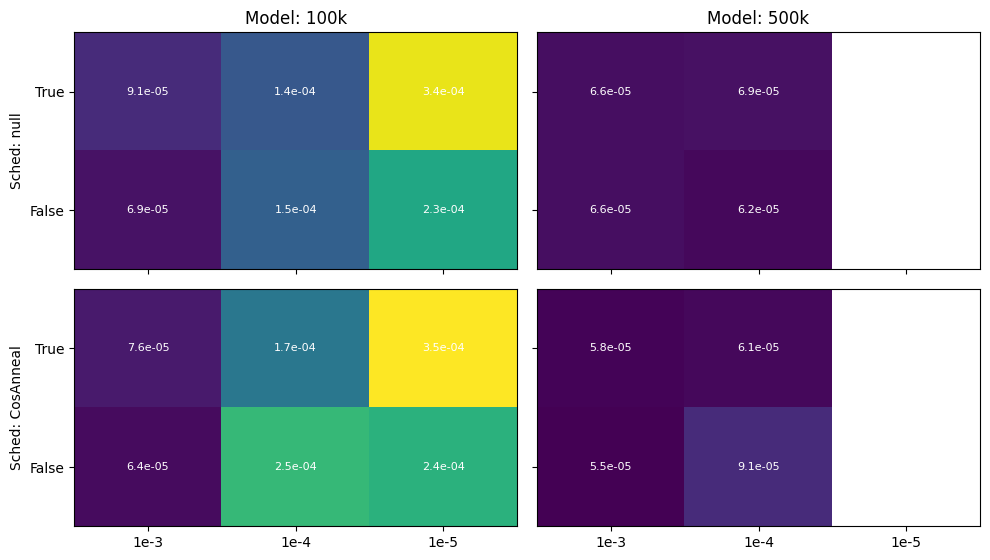

In [61]:
import numpy as np

# Define grid axes
model_sizes = ['100k', '500k']
perm_inv_flags = ['True', 'False']
lrs = ['1e-3', '1e-4', '1e-5']
scheds = ['null', 'CosAnneal']

# Initialize 4D grid with NaNs
val_grid = np.full((len(model_sizes), len(perm_inv_flags), len(lrs), len(scheds)), np.nan)

# Fill the grid
for key, val in best_val.items():
    for i, ms in enumerate(model_sizes):
        if ms in key:
            for j, pi in enumerate(perm_inv_flags):
                if f'perm_inv_{pi}' in key:
                    for k, lr in enumerate(lrs):
                        if f'lr_{lr}' in key:
                            for l, sched in enumerate(scheds):
                                if f'sched_{sched}' in key:
                                    val_grid[i, j, k, l] = val


# Plotting grid: rows = scheds, cols = model_sizes
fig, axs = plt.subplots(
    nrows=len(scheds),
    ncols=len(model_sizes),
    figsize=(10, 6),
    sharex=True,
    sharey=True
)

for i, sched in enumerate(scheds):         # rows
    for j, ms in enumerate(model_sizes):   # cols
        ax = axs[i, j]
        data = val_grid[j, :, :, i]  # Shape: [perm_inv, lr]
        im = ax.imshow(data, cmap='viridis', aspect='auto', vmin=np.nanmin(val_grid), vmax=np.nanmax(val_grid))

        # Set ticks
        ax.set_xticks(np.arange(len(lrs)))
        ax.set_xticklabels(lrs)
        ax.set_yticks(np.arange(len(perm_inv_flags)))
        ax.set_yticklabels(perm_inv_flags)

        # Titles and labels
        if i == 0:
            ax.set_title(f"Model: {ms}")
        if j == 0:
            ax.set_ylabel(f"Sched: {sched}")

        # Annotate values
        for pi in range(len(perm_inv_flags)):
            for lr in range(len(lrs)):
                val = data[pi, lr]
                if not np.isnan(val):
                    ax.text(lr, pi, f"{val:.1e}", ha="center", va="center", color="white", fontsize=8)

# fig.suptitle("Validation Loss Heatmaps\nRows: perm_inv | Columns: lr", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
# cbar.set_label("Validation Loss")
fig.savefig("val_loss_heatmap1.pdf", dpi=300)
plt.show()

In [62]:
def load_model_paths(base_dir):
    model_dict = {}
    
    # Recursively search for best.pth files
    pattern = os.path.join(base_dir, "**/model/best.pth")
    model_paths = glob.glob(pattern, recursive=True)
    
    for path in model_paths:
        # Extract folder name containing the model info
        model_dir_name = os.path.basename(os.path.dirname(os.path.dirname(path)))
        
        # Remove timestamp and '-naive-hs-' if present
        cleaned_name = model_dir_name
        if '-' in cleaned_name:
            cleaned_name = '-'.join(cleaned_name.split('-')[1:])  # Remove the timestamp part
        cleaned_name = cleaned_name.replace("naive-", "")      # Remove this literal string
        
        model_dict[cleaned_name] = path
    
    return model_dict

# Example usage:
base_folder = "/Users/jamarino/Downloads/hyperparam-search second round"
model_dict = dict(sorted(load_model_paths(base_folder).items()))

best_val_models = {}
best_val = {}
for k, v in model_dict.items():
    print(f"{k}: {v}")
    best_val_models[k] = torch.load(v, map_location=torch.device('cpu'))
    print("Best_val_loss:", np.min(best_val_models[k]["losses"]["val"]), np.argmin(best_val_models[k]["losses"]["val"]))
    best_val[k] = np.min(best_val_models[k]["losses"]["val"])


100k-perm_inv_True-L1-lr_1e-3-sched_CosAnneal-factor_ppd: /Users/jamarino/Downloads/hyperparam-search second round/0414_095023-100k-naive-perm_inv_True-L1-lr_1e-3-sched_CosAnneal-factor_ppd/model/best.pth
Best_val_loss: 0.11094669252634048 147
100k-perm_inv_True-L1-lr_1e-3-sched_ReduceLROnPlateau-factor_ppd: /Users/jamarino/Downloads/hyperparam-search second round/0414_095017-100k-naive-perm_inv_True-L1-lr_1e-3-sched_ReduceLROnPlateau-factor_ppd/model/best.pth
Best_val_loss: 0.10709609091281891 148
100k-perm_inv_True-L1-lr_1e-3-sched_null-factor_ppd: /Users/jamarino/Downloads/hyperparam-search second round/0414_094820-100k-naive-perm_inv_True-L1-lr_1e-3-sched_null-factor_ppd/model/best.pth
Best_val_loss: 0.11504650115966797 141
100k-perm_inv_True-MSE-lr_1e-3-sched_CosAnneal: /Users/jamarino/Downloads/hyperparam-search second round/0411_191342-100k-naive-perm_inv_True-MSE-lr_1e-3-sched_CosAnneal/model/best.pth
Best_val_loss: 5.4253188864095137e-05 149
100k-perm_inv_True-MSE-lr_1e-3-sche

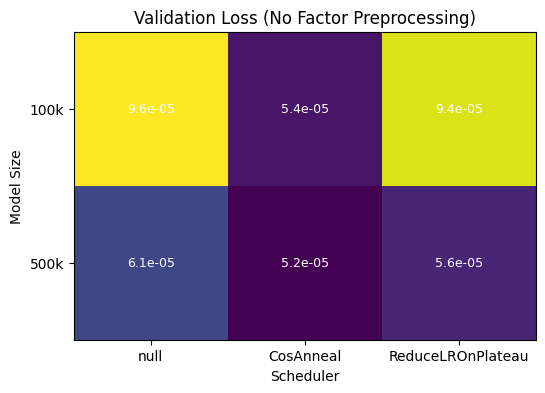

In [63]:
# Define grid axes
model_sizes = ['100k', '500k']
# perm_inv_flags = ['True', 'False']
# lrs = ['1e-3', '1e-4', '1e-5']
scheds = ['null', 'CosAnneal', 'ReduceLROnPlateau']
factor_preprocessing = ['True', 'False']

# Initialize 2D grid: [model_size, scheduler]
val_grid = np.full((len(model_sizes), len(scheds)), np.nan)

# Fill the grid
for key, val in best_val.items():
    if 'factor_ppd' in key:
        continue  # Skip models with factor preprocessing

    for i, ms in enumerate(model_sizes):
        if ms in key:
            for j, sched in enumerate(scheds):
                if f'sched_{sched}' in key:
                    val_grid[i, j] = val

# Plotting heatmap
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(val_grid, cmap='viridis', vmin=np.nanmin(val_grid), vmax=np.nanmax(val_grid))

# Set ticks
ax.set_xticks(np.arange(len(scheds)))
ax.set_xticklabels(scheds)
ax.set_yticks(np.arange(len(model_sizes)))
ax.set_yticklabels(model_sizes)

# Axis labels
ax.set_xlabel("Scheduler")
ax.set_ylabel("Model Size")
ax.set_title("Validation Loss (No Factor Preprocessing)")

# Annotate values
for i in range(len(model_sizes)):
    for j in range(len(scheds)):
        val = val_grid[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.1e}", ha="center", va="center", color="white", fontsize=9)

# Colorbar
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
# cbar.set_label("Validation Loss")
fig.savefig("val_loss_heatmap2.pdf", dpi=300)
plt.show()

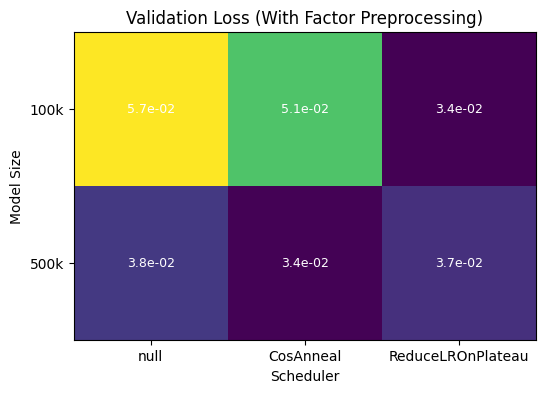

In [64]:
# Define grid axes
model_sizes = ['100k', '500k']
# perm_inv_flags = ['True', 'False']
# lrs = ['1e-3', '1e-4', '1e-5']
scheds = ['null', 'CosAnneal', 'ReduceLROnPlateau']
factor_preprocessing = ['True', 'False']

# Initialize 2D grid: [model_size, scheduler]
val_grid = np.full((len(model_sizes), len(scheds)), np.nan)

# Fill the grid
for key, val in best_val.items():
    if 'factor_ppd' not in key:
        continue  # Skip models with factor preprocessing
    for i, ms in enumerate(model_sizes):
        if ms in key:
            for j, sched in enumerate(scheds):
                if f'sched_{sched}' in key:
                    val_grid[i, j] = val

# Plotting heatmap
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(val_grid, cmap='viridis', vmin=np.nanmin(val_grid), vmax=np.nanmax(val_grid))

# Set ticks
ax.set_xticks(np.arange(len(scheds)))
ax.set_xticklabels(scheds)
ax.set_yticks(np.arange(len(model_sizes)))
ax.set_yticklabels(model_sizes)

# Axis labels
ax.set_xlabel("Scheduler")
ax.set_ylabel("Model Size")
ax.set_title("Validation Loss (With Factor Preprocessing)")

# Annotate values
for i in range(len(model_sizes)):
    for j in range(len(scheds)):
        val = val_grid[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.1e}", ha="center", va="center", color="white", fontsize=9)

# Colorbar
# Colorbar
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
# cbar.set_label("Validation Loss")
fig.savefig("val_loss_heatmap3.pdf", dpi=300)
plt.show()